# __NLP on the SocialBuzz Sentiment Analysis Dataset from Kaggle__

#### The purpose of this notebook is to classify social media posts from a kaggle dataset.

_Kelby Mace 2/7/2026_

TODO:

-Try other classifiers (SVM, etc.)

In [16]:
# import kagglehub
import pandas as pd
import numpy as np
import nltk
import sklearn
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
import spacy
import wordninja
import shap
import gensim.downloader as api
from sklearn.svm import LinearSVC


# # Download latest version
# path = kagglehub.dataset_download("eshummalik/socialbuzz-sentiment-analytics")

# print("Path to dataset files:", path)

## __Data Preprocessing & Feature Engineering__

In [3]:
df = pd.read_csv("sentimentdataset.csv")

# Fix data tytpes
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Likes'] = df['Likes'].astype(int)
df['Retweets'] = df['Retweets'].astype(int)

df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19


In [4]:
# Clean text

def clean_text(text):
    """Lowercase, strip whitespace, remove punctuation, and replace numbers with <NUM>."""
    text = text.lower()
    text = text.strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'[0-9]', '<NUM>', text)
    return text


# Apply text cleaning function
df['Text'] = df['Text'].apply(clean_text)
df['Sentiment'] = df['Sentiment'].apply(lambda x: x.strip().lower())

#Add text length feature
df['Text Length'] = df['Text'].apply(len)

# Drop extra index columns
if 'Unnamed: 0.1' in df.columns:
    df = df.drop(columns=['Unnamed: 0.1'])
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Text Length
0,enjoying a beautiful day at the park,positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,36
1,traffic was terrible this morning,negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,33
2,just finished an amazing workout,positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,33
3,excited about the upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,42
4,trying out a new recipe for dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,42


In [ ]:
# So many sentiment categories! Going to have to reduce them
df['Sentiment'].value_counts()

Sentiment
positive          45
joy               44
excitement        37
contentment       19
neutral           18
                  ..
lostlove           1
emotionalstorm     1
suffering          1
bittersweet        1
intrigue           1
Name: count, Length: 191, dtype: int64

In [ ]:
## Comment out after initial run - save off csv with cleaned text and new feature

## Use a pre-trained zero-shot classifier from Hugging Face to map sentiment categories to positive, neutral, or negative
# candidate = ["positive", "neutral", "negative"]
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# def map_label(label: str):
#     out = classifier(label, candidate_labels=candidate, multi_label=False)
#     return out["labels"][0], out["scores"][0]  # predicted class + confidence

# # Example
# map_label("furious")


In [ ]:
## See how zero-shot classification does on the actual text
## This takes a really long time so I only did it once

# df['Predicted Sentiment'] = df['Text'].apply(lambda x: map_label(x)[0])
# df['Prediction Confidence'] = df['Text'].apply(lambda x: map_label(x)[1])

# df.head()

In [ ]:
# Hardly any neutral... that will make it really tough to train
df['Predicted Sentiment'].value_counts(normalize=True)

Predicted Sentiment
positive    0.684426
negative    0.278689
neutral     0.036885
Name: proportion, dtype: float64

In [18]:
df.loc[df['Prediction Confidence'] == df['Prediction Confidence'].min()]

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Text Length,Predicted Sentiment,Prediction Confidence
349,contemplating lifes mysteries under the starry...,contemplation,2016-07-02 23:30:00,Stargazer,Twitter,#Contemplation #StarryNight,28,55,UK,2016,7,2,23,56,negative,0.348642


In [ ]:
## Apply zero-shot again to the actual sentiment rather than the text itself

# df['Sentiment Reduced'], df['Sentiment Reduced Confidence'] = zip(*df['Sentiment'].apply(lambda x: map_label(x)))

In [ ]:
## Save as csv so I don't have to run the zero-shot classification again
# df.to_csv("sentiment_with_predictions.csv", index=False)

In [ ]:
# For sentiments already classified as positive, neutral, or negative, how often does the predicted sentiment match the original sentiment?

df_three = df.copy()

df_three = df_three.loc[df_three['Sentiment'].isin(["positive", "neutral", "negative"])]
df_three['Text Sentiment Match'] = df_three.apply(lambda row: row['Sentiment'] == row['Predicted Sentiment'], axis=1)

# This works 100% of the time -- good gut check
df_three['Sentiment Prediction Match'] = df_three.apply(lambda row: row['Sentiment'] == row['Sentiment Reduced'], axis=1)

df_three['Predictions Match'] = df_three.apply(lambda row: row['Text Sentiment Match'] == row['Sentiment Prediction Match'], axis=1)

df_three['Text Sentiment Match'].value_counts(normalize=True), df_three['Sentiment Prediction Match'].value_counts(normalize=True), df_three['Predictions Match'].value_counts(normalize=True)

(Text Sentiment Match
 True     0.671642
 False    0.328358
 Name: proportion, dtype: float64,
 Sentiment Prediction Match
 True    1.0
 Name: proportion, dtype: float64,
 Predictions Match
 True     0.671642
 False    0.328358
 Name: proportion, dtype: float64)

### __Load in CSV After Zero Shot Classification__

In [2]:
df = pd.read_csv("sentiment_with_predictions.csv")

# Rename columns so they aren't so confusing
df = df.rename(columns={
    "Predicted Sentiment": "Text Predicted Sentiment",
    "Prediction Confidence": "Text Prediction Confidence",
    "Sentiment Reduced": "Sentiment Predicted Sentiment",
    "Sentiment Reduced Confidence": "Sentiment Prediction Confidence"
    })

# Clean up the Hashtags, Platform, Country columns that I overlooked previously
df['Hashtags'] = df['Hashtags'].apply(lambda x: x.strip().lower())
df['Hashtags'] = df['Hashtags'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df['Platform'] = df['Platform'].apply(lambda x: x.strip().lower())
df['Country'] = df['Country'].apply(lambda x: x.strip().lower())

# Create a new feature for the number of hashtags by counting the number of words in the cleaned Hashtags column
df['Num Hashtags'] = df['Hashtags'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

# Split words in hashtags (this substantially increased macro avg)
df['Hashtags'] = df['Hashtags'].apply(lambda x: wordninja.split(x) if pd.notnull(x) else [])
df['Hashtags'] = df['Hashtags'].apply(lambda x: " ".join(x))

df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Text Length,Text Predicted Sentiment,Text Prediction Confidence,Sentiment Predicted Sentiment,Sentiment Prediction Confidence,Num Hashtags
0,enjoying a beautiful day at the park,positive,2023-01-15 12:30:00,User123,twitter,nature park,15,30,usa,2023,1,15,12,36,positive,0.936028,positive,0.987529,2
1,traffic was terrible this morning,negative,2023-01-15 08:45:00,CommuterX,twitter,traffic morning,5,10,canada,2023,1,15,8,33,negative,0.976853,negative,0.988335,2
2,just finished an amazing workout,positive,2023-01-15 15:45:00,FitnessFan,instagram,fitness workout,20,40,usa,2023,1,15,15,32,positive,0.923207,positive,0.987529,2
3,excited about the upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,facebook,travel adventure,8,15,uk,2023,1,15,18,42,positive,0.975727,positive,0.987529,2
4,trying out a new recipe for dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,instagram,cooking food,12,25,australia,2023,1,15,19,42,positive,0.662256,neutral,0.855826,2


### __Examine Zero Shot Performance__

In [3]:
sentiments = ['positive', 'neutral', 'negative']

other_sentiments = df.loc[~df['Sentiment'].isin(sentiments)][['Text','Sentiment', 'Text Predicted Sentiment', 'Sentiment Predicted Sentiment', 'Text Prediction Confidence', 'Sentiment Prediction Confidence']]

other_sentiments.loc[other_sentiments['Sentiment Prediction Confidence'] < 0.5]

,Text,Sentiment,Text Predicted Sentiment,Sentiment Predicted Sentiment,Text Prediction Confidence,Sentiment Prediction Confidence
299,yearning for a touch thats not there echoes of...,yearning,negative,positive,0.558199,0.393416
321,yearning for the warmth of a vanished sun a he...,yearning,negative,positive,0.920840,0.393416
356,reflecting on personal growth achieved through...,reflection,positive,positive,0.831560,0.445453
393,exploring the universe within during a mindful...,innerjourney,positive,positive,0.537221,0.423696
397,reflective contemplation amid the ruins of a f...,reflection,neutral,positive,0.517170,0.445453
490,standing before the grandeur of the eiffel tow...,reflection,positive,positive,0.738599,0.445453
508,in the tranquility of kyotos bamboo forest whi...,tranquility,positive,neutral,0.557854,0.499439
510,at the front row of adeles concert each note o...,emotion,positive,positive,0.904690,0.382542
522,immersed in the soulful melodies of adele tear...,emotion,positive,positive,0.380305,0.382542
552,facing a defeat in the championship the boxer ...,reflection,negative,positive,0.768080,0.445453


In [4]:
# Use the highest confidence level, unless both are below 0.5, in which case we will classify as neutral

def final_sentiment(row):
    if row['Sentiment Prediction Confidence'] >= row['Text Prediction Confidence'] and row['Sentiment Prediction Confidence']  >= 0.5:
        return row['Sentiment Predicted Sentiment']
    elif row['Text Prediction Confidence'] >= row['Sentiment Prediction Confidence'] and row['Text Prediction Confidence'] >= 0.5:
        return row['Text Predicted Sentiment']
    else:
        return 'neutral'

df['Final Sentiment'] = df.apply(final_sentiment, axis=1)
df['Final Sentiment'].value_counts(normalize=True)

# Remove neutrals because they are too small of a category to train on
# Trying to do unsupervised learning, not zero-shot to logistic regression comparison
# Take neutrals out for now
df = df.loc[df['Final Sentiment'] != 'neutral']

### __Define Target and Features__

In [5]:
target_col = "Final Sentiment" # column to classify
text_col = "Text"

# remove columns I don't want as predictors
drop_cols = [
    target_col,
    "Sentiment",
    "Text Predicted Sentiment",
    "Sentiment Predicted Sentiment",
    "Text Prediction Confidence",
    "Sentiment Prediction Confidence",
    "Timestamp",
    "User"
]

df_model = df.copy()
df_model = df_model.dropna(subset=[target_col, text_col])

X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns], errors="ignore")
y = df_model[target_col]

# Auto-detect other feature types (excluding text)
text_features = ["Text", "Hashtags"]
numeric_features = [c for c in X.select_dtypes(include=[np.number]).columns if c not in text_features]
categorical_features = [c for c in X.select_dtypes(include=["object", "category", "bool"]).columns if c not in text_features]

print("Text features:", text_features)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Text features: ['Text', 'Hashtags']
Numeric features: ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour', 'Text Length', 'Num Hashtags']
Categorical features: ['Platform', 'Country']


## __Logistic Regression with TF-IDF__

_Experiment 1: Stop word removal, but no stemming or lemmatization_

In [6]:
# Experiment 1: No stemming/lemmatization, stop word removal

# A few words like "not" are important for sentiment, so remove them from the stopword list
custom_stopwords = set(text.ENGLISH_STOP_WORDS) - {"not", "no", "never"}
custom_stopwords = sorted(list(custom_stopwords))  # convert set -> list

text_transformer = TfidfVectorizer(
    stop_words=custom_stopwords,   # custom stopword list with negative words retained
    ngram_range=(1,2),
    min_df=2
)

hashtags_transformer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # works with sparse output
])

# Use one-hot encoding for categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "Text"),
        ("hashtags", hashtags_transformer, "Hashtags"),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

### __Fit and Train Model, then Examine Feature Importance__

In [7]:
# Create model pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=10000))
])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fit model to training data
clf.fit(X_train, y_train)


# Look at feature importances
model = clf.named_steps["model"]
pre = clf.named_steps["preprocessor"]

feature_names = pre.get_feature_names_out()
classes = model.classes_
coefs = model.coef_

print("classes:", classes)
print("coef shape:", coefs.shape)

top_k = 20

if coefs.shape[0] == 1:
    # Binary case: coefficients are for classes[1] vs classes[0]
    pos_class = classes[1]
    neg_class = classes[0]
    w = coefs[0]

    top_pos = np.argsort(w)[-top_k:][::-1]
    top_neg = np.argsort(w)[:top_k]

    print(f"\nTop features pushing toward class '{pos_class}'")
    print(pd.DataFrame({"feature": feature_names[top_pos], "coef": w[top_pos]}))

    print(f"\nTop features pushing toward class '{neg_class}'")
    print(pd.DataFrame({"feature": feature_names[top_neg], "coef": w[top_neg]}))
else:
    # Multiclass case
    for i, cls in enumerate(classes):
        idx = np.argsort(coefs[i])[-top_k:][::-1]
        print(f"\nTop features for class = {cls}")
        print(pd.DataFrame({"feature": feature_names[idx], "coef": coefs[i, idx]}))

classes: ['negative' 'positive']
coef shape: (1, 1550)

Top features pushing toward class 'positive'
                    feature      coef
0          hashtags__senior  1.183278
1                 text__new  0.879317
2   hashtags__determination  0.861353
3       hashtags__curiosity  0.839066
4        hashtags__serenity  0.790514
5       hashtags__nostalgia  0.710293
6      hashtags__creativity  0.689476
7       hashtags__gratitude  0.657603
8          hashtags__nature  0.594407
9                 text__joy  0.584283
10     hashtags__compassion  0.581496
11            hashtags__art  0.565245
12          text__curiosity  0.561004
13            text__friends  0.560431
14     hashtags__acceptance  0.543093
15             text__beauty  0.538321
16          hashtags__pride  0.536148
17      text__determination  0.535058
18       hashtags__euphoria  0.533846
19       hashtags__inspired  0.528812

Top features pushing toward class 'negative'
                      feature      coef
0           has

### __Model Evaluation__

              precision    recall  f1-score   support

    negative       0.96      0.64      0.77        42
    positive       0.87      0.99      0.92        99

    accuracy                           0.89       141
   macro avg       0.92      0.82      0.85       141
weighted avg       0.90      0.89      0.88       141

ROC-AUC: 0.9232804232804233


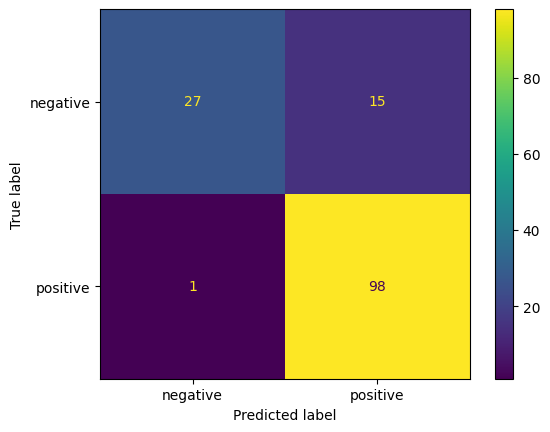

In [8]:
# Evaluate on test set
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # binary classification

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

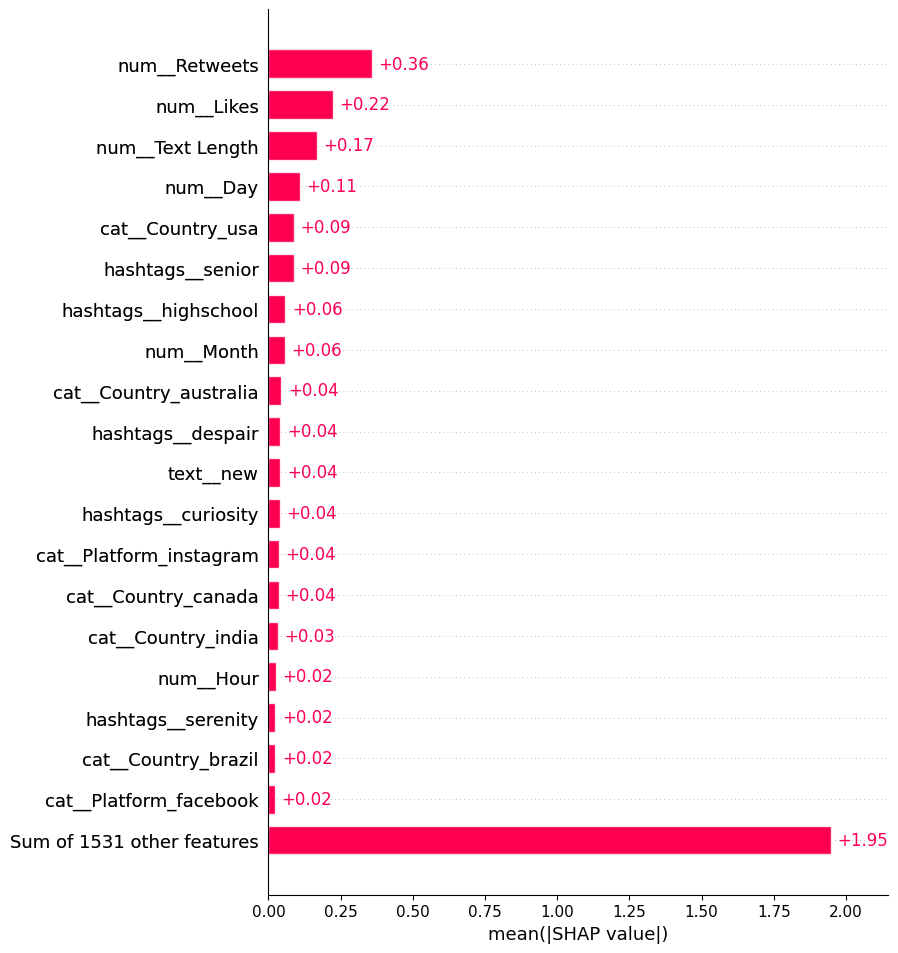

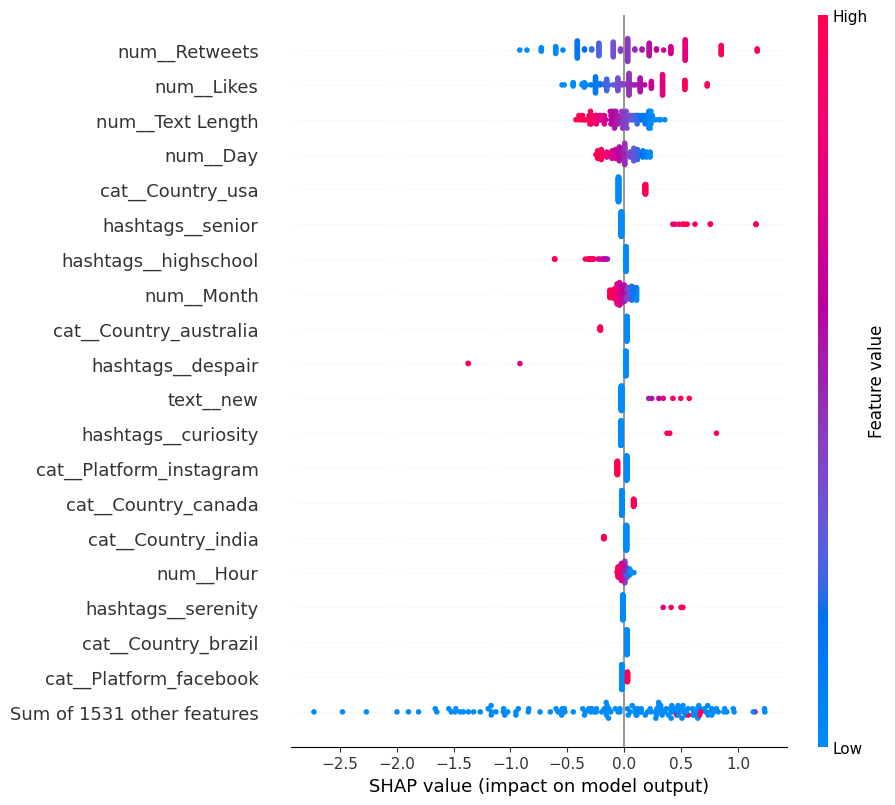

In [9]:
# 1) Split pipeline into preprocessor + classifier
preprocess = clf[:-1]          # all steps except final estimator
model = clf[-1]                # final estimator (e.g., LogisticRegression)

# 2) Transform data using pipeline preprocessing
X_train_t = preprocess.transform(X_train)
X_test_t = preprocess.transform(X_test)

# 3) Build SHAP explainer on the linear model
explainer = shap.LinearExplainer(model, X_train_t)
shap_values = explainer(X_test_t)

# 4) Optional: add feature names (great for TF-IDF/CountVectorizer)
feature_names = preprocess.get_feature_names_out().tolist()
shap_values.feature_names = feature_names

# 5) Plots
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)


### __Experiment 2: Logistic Regression with Lemmatization__

Slightly worse with lemmatization

In [10]:
# Try lemmatization
df_model = df.copy()

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_text(s):
    if not isinstance(s, str):
        return ""
    doc = nlp(s.lower())
    return " ".join(tok.lemma_ for tok in doc if not tok.is_punct and not tok.is_space)

# Apply to text columns used by TF-IDF
df_model["Text_lemma"] = df_model["Text"].apply(lemmatize_text)
df_model["Hashtags_lemma"] = df_model["Hashtags"].apply(
    lambda tags: lemmatize_text(" ".join(tags) if isinstance(tags, list) else str(tags))
)

In [11]:
target_col = "Final Sentiment" # column to classify
text_col = "Text_lemma"

# remove columns I don't want as predictors
drop_cols = [
    target_col,
    "Sentiment",
    "Text Predicted Sentiment",
    "Sentiment Predicted Sentiment",
    "Text Prediction Confidence",
    "Sentiment Prediction Confidence",
    "Timestamp",
    "User",
    "Text",
    "Hashtags"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "Text_lemma"),
        ("hashtags", hashtags_transformer, "Hashtags_lemma"),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

df_model = df_model.dropna(subset=[target_col, text_col])

X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns], errors="ignore")
y = df_model[target_col]

# Auto-detect other feature types (excluding text)
text_features = ["Text_lemma", "Hashtags_lemma"]
numeric_features = [c for c in X.select_dtypes(include=[np.number]).columns if c not in text_features]
categorical_features = [c for c in X.select_dtypes(include=["object", "category", "bool"]).columns if c not in text_features]

print("Text features:", text_features)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


# Create model pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=10000))
])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fit model to training data
clf.fit(X_train, y_train)
# Evaluate on test set
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Text features: ['Text_lemma', 'Hashtags_lemma']
Numeric features: ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour', 'Text Length', 'Num Hashtags']
Categorical features: ['Platform', 'Country']
              precision    recall  f1-score   support

    negative       0.96      0.62      0.75        42
    positive       0.86      0.99      0.92        99

    accuracy                           0.88       141
   macro avg       0.91      0.80      0.84       141
weighted avg       0.89      0.88      0.87       141

Confusion matrix:
 [[26 16]
 [ 1 98]]


## __Try GloVe Instead of TF-IDF__

Classification report:
              precision    recall  f1-score   support

    negative       0.88      0.83      0.85        42
    positive       0.93      0.95      0.94        99

    accuracy                           0.91       141
   macro avg       0.90      0.89      0.90       141
weighted avg       0.91      0.91      0.91       141

ROC-AUC: 0.9615199615199614


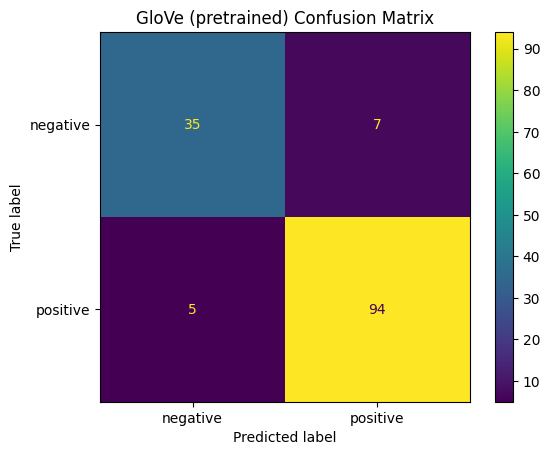

In [21]:
TEXT_COL = "Text_lemma"
TARGET_COL = "Final Sentiment"  # <- change if needed
EMBEDDING_NAME = "glove-twitter-100"  # pretrained word vectors (100d)


if all(name in globals() for name in ["X_train", "X_test", "y_train", "y_test"]):
    # If X_train/X_test are DataFrames, pull TEXT_COL; if they are Series, use directly
    train_text = X_train[TEXT_COL] if hasattr(X_train, "columns") else X_train
    test_text = X_test[TEXT_COL] if hasattr(X_test, "columns") else X_test
else:
    X = df[TEXT_COL].astype(str)
    y = df[TARGET_COL]
    train_text, test_text, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

train_text = train_text.astype(str)
test_text = test_text.astype(str)


# Load pretrained embeddings
# First run downloads vectors; later runs load from local cache

kv = api.load(EMBEDDING_NAME)
dim = kv.vector_size

# Text -> averaged embedding

token_pattern = re.compile(r"[a-zA-Z']+")

def tokenize(s):
    return token_pattern.findall(s.lower())

def mean_embed(text):
    toks = tokenize(text)
    vecs = [kv[w] for w in toks if w in kv]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_train_vec = np.vstack([mean_embed(t) for t in train_text])
X_test_vec = np.vstack([mean_embed(t) for t in test_text])

# Train classifier

clf_glv = LogisticRegression(max_iter=3000, n_jobs=None)
clf_glv.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf_glv.predict(X_test_vec)

print("Classification report:")
print(classification_report(y_test, y_pred))

# ROC-AUC only for binary labels
if len(np.unique(y_train)) == 2:
    y_prob = clf_glv.predict_proba(X_test_vec)[:, 1]
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("GloVe (pretrained) Confusion Matrix")
plt.show()


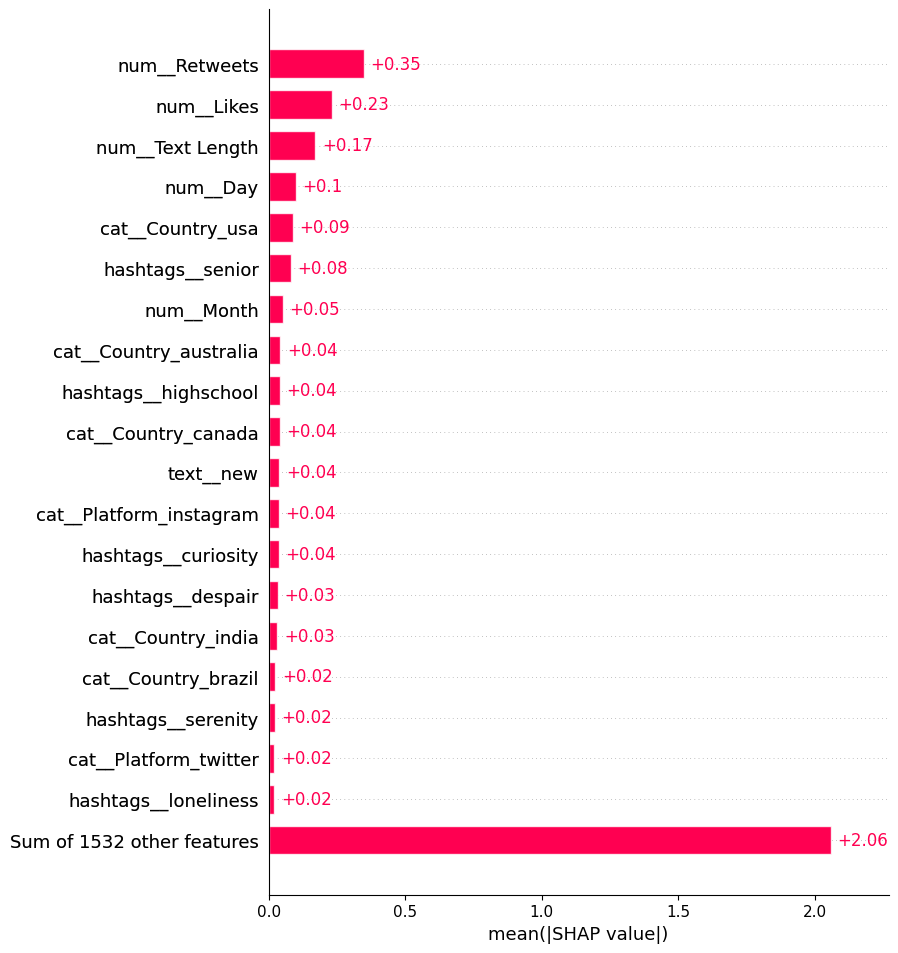

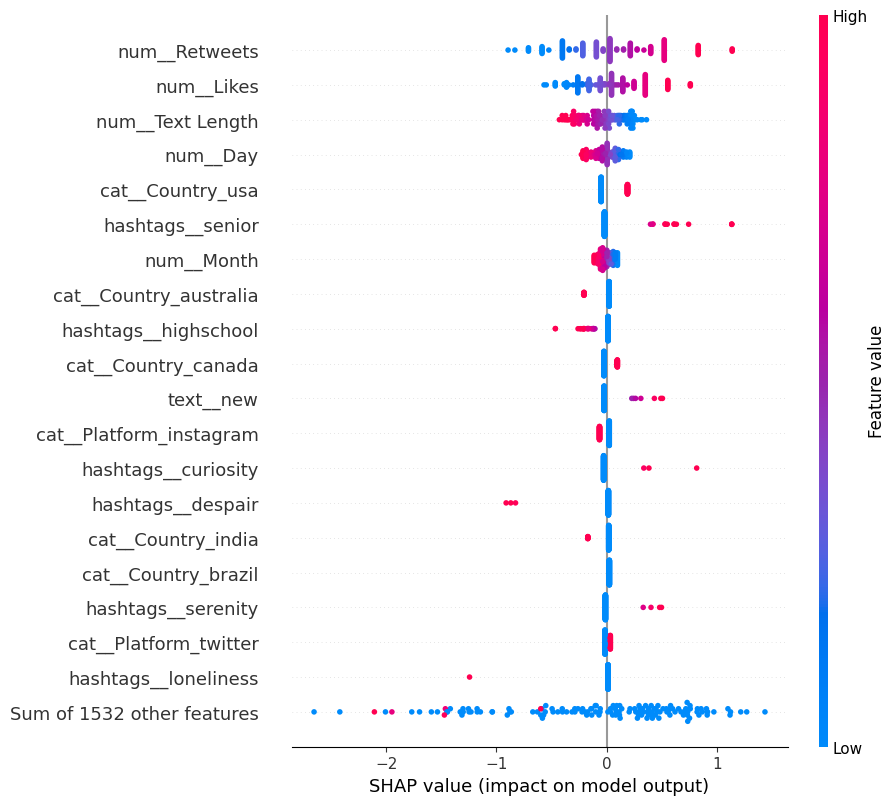

In [14]:
# 1) Split pipeline into preprocessor + classifier
preprocess = clf[:-1]          # all steps except final estimator
model = clf[-1]                # final estimator (e.g., LogisticRegression)

# 2) Transform data using pipeline preprocessing
X_train_t = preprocess.transform(X_train)
X_test_t = preprocess.transform(X_test)

# 3) Build SHAP explainer on the linear model
explainer = shap.LinearExplainer(model, X_train_t)
shap_values = explainer(X_test_t)

# 4) Optional: add feature names (great for TF-IDF/CountVectorizer)
feature_names = preprocess.get_feature_names_out().tolist()
shap_values.feature_names = feature_names

# 5) Plots
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)

## __Try GloVe with Linear Support Vector Machines (SVM)__

_A little worse than logistic regression, but better than logistic regression with TF-IDF_

Classification report:
              precision    recall  f1-score   support

    negative       0.80      0.83      0.81        42
    positive       0.93      0.91      0.92        99

    accuracy                           0.89       141
   macro avg       0.86      0.87      0.87       141
weighted avg       0.89      0.89      0.89       141

ROC-AUC: 0.9559884559884559


Text(0.5, 1.0, 'GloVe + Linear SVM Confusion Matrix')

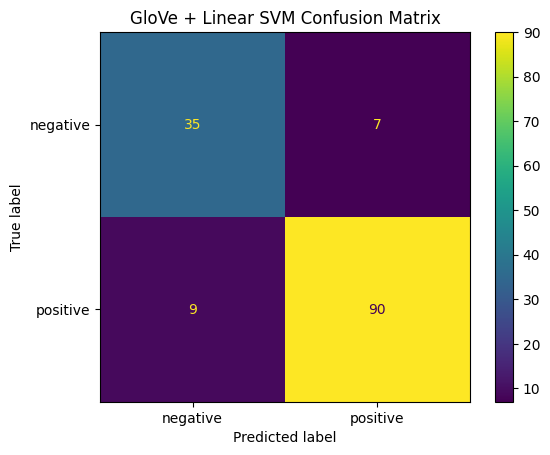

In [ ]:
# Train only the new classifier
clf_svm = LinearSVC(C=1.0, max_iter=2000)
clf_svm.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf_svm.predict(X_test_vec)

print("Classification report:")
print(classification_report(y_test, y_pred))

# ROC-AUC for binary classification (LinearSVC uses decision_function, not predict_proba)
if len(np.unique(y_train)) == 2:
    y_score = clf_svm.decision_function(X_test_vec)
    print("ROC-AUC:", roc_auc_score(y_test, y_score))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("GloVe + Linear SVM Confusion Matrix")